In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio 
import h5py
from v1_data import V1
import os
import os.path

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, GRU, CuDNNLSTM, Flatten, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import RMSprop, SGD, Adam
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
import time 

# set plots inside notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

N_COMPLEX = len(os.listdir('./RustV1/complex/data/'))
N_SIMPLE = len(os.listdir('./RustV1/simple/data/'))
cell_nums = {'simple':N_SIMPLE, 'complex':N_COMPLEX}

In [2]:
# performance
import scipy as sp
def neglogli(preds, actual):
    preds = np.reshape(preds, (-1,))
    nll = np.sum((preds - actual*np.log(preds + 1e-07) + np.log(sp.special.factorial(actual))))
    return nll

def poiss_full(y, yhat):
    cost = tf.reduce_mean(tf.nn.log_poisson_loss(y, tf.log(yhat+1e-7), compute_full_loss=True))
    costp = tf.reduce_mean(tf.nn.log_poisson_loss(y, tf.log(y+1e-7), compute_full_loss=True))
    return cost 

import scipy.misc as spm
def get_bps(model, data):
    
    preds = model.predict(data.X_test)

    avg_rate = float(np.sum(data.y_train)) / len(data.y_train)
    avg_pred = np.zeros_like(data.y_test)
    avg_pred.fill(avg_rate)
    nll_avg = neglogli(avg_pred, data.y_test.T)

    nll_model = neglogli(preds, data.y_test.T)
    
    nsp = np.sum(data.y_test)

    nll_perfect = neglogli(data.y_test.T, data.y_test.T)
    bps_perfect = abs((nll_perfect-nll_avg) / nsp / np.log(2))

    bps = abs((nll_model-nll_avg) / nsp / np.log(2))
    if nll_model > nll_avg:
        bps *= -1
    return bps, bps_perfect

def r2(preds, actual):
    preds = np.reshape(preds, (-1,))
    r = np.corrcoef(preds, actual)[0,1]
    rsq = r ** 2
    return r,rsq

def restore_performance_checkpt(path):
    if os.path.exists(path) and os.path.isfile(path):
        performance = np.genfromtxt(path, delimiter=',')
        return performance
    else: print ('File Not Found Error: ' + path); return None;

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [3]:
def gen_fc_model(H, dim=20, L=0, verbose=True): 
    model = Sequential()
    model.add(Dense(H, input_dim=dim))
    model.add(Activation('softplus'))
    if H >= 50 and H < 100: 
        model.add(Dropout(.1))
    elif H >= 100:
         model.add(Dropout(.2))

    for _ in range(L):
        model.add(Dense(H))
        model.add(Activation('softplus'))
        if H >= 50 and H < 100: 
            model.add(Dropout(.2))
        elif H >= 100:
            model.add(Dropout(.4))

    model.add(Dense(1, activation='softplus'))
    
    adam = Adam(lr=.0001, decay=1e-6)
    model.compile(loss=poiss_full, optimizer=adam) #metrics=['mean_squared_error']

    if verbose:
        model.summary()
        
    return model

def gen_rnn_model(H, dim=20, n_frames=16, L=0, verbose=True, use_cudnn=True):
    model = Sequential()
    if L == 0: ret_seqs = False;
    else: ret_seqs = True;
    
        
    if use_cudnn: lstm = CuDNNLSTM;
    else: lstm = LSTM;
        
    model.add(lstm(H, input_shape=(n_frames, dim), return_sequences=ret_seqs))
    
    for i in range(L):
        if i == L-1: ret_seqs = False;
        else: ret_seqs = True
        model.add(lstm(H, return_sequences=ret_seqs)) 
    
    model.add(Dense(1, activation='softplus'))
    
    if verbose:
        model.summary()
    
    adam = Adam(lr=.001, decay=1e-6)

    model.compile(loss=poiss_full, optimizer=adam) 
    return model

def gen_cnn_model(H, L=0, dim=1, n_frames=16, ksize=7, verbose=True):
    model = Sequential()
    
    
    model.add(Conv1D(H, ksize, activation='softplus', padding='same', input_shape=(n_frames, dim)))
    model.add(Conv1D(H, ksize, activation='softplus', padding='same'))
    
    if L > 0:
        model.add(MaxPooling1D(2))
        if H > 16: model.add(Dropout(.3));
    
    H_curr = H
    for i in range(L):
        model.add(Conv1D(H_curr, ksize-2*(i+1), padding='same', activation='softplus')) # 2x kernels after each downsample
        model.add(Conv1D(H_curr, ksize-2*(i+1), padding='same', activation='softplus'))
        model.add(MaxPooling1D(2))
        drop = 0.0
        if H > 16: drop = .3;
        if H > 32: drop = .5;
        model.add(Dropout(drop))
        H_curr *= 2
        
    model.add(GlobalAveragePooling1D())
    if H > 16 and H < 64 and L > 0: model.add(Dropout(0.3)); 
    if H > 32 and L > 0: model.add(Dropout(0.5)); 
    model.add(Dense(1, activation='softplus'))
    
    if verbose:
        model.summary()
    
    if L > 2: eta = .0001
    else: eta = .001
    adam = Adam(lr=eta, decay=1e-6)

    model.compile(loss=poiss_full, optimizer=adam) 
    return model
        

In [4]:
h_layers_fc = [0,1,2,3]
h_sizes_fc = [1,2,3,4,5,16,32,64,128]

h_layers_rnn = [0,1,2]
h_sizes_rnn = [2,5,10,25,50]

h_layers_cnn = [0,1,2,3]
h_sizes_cnn = [2,4,8,16,32,64]

hparams = {'fc':{'h_layers':h_layers_fc, 'h_sizes':h_sizes_fc, 'ndepths':len(h_layers_fc), 'nwidths':len(h_sizes_fc)},
          'rnn':{'h_layers':h_layers_rnn, 'h_sizes':h_sizes_rnn, 'ndepths':len(h_layers_rnn), 'nwidths':len(h_sizes_rnn)},
          'cnn':{'h_layers':h_layers_cnn, 'h_sizes':h_sizes_cnn, 'ndepths':len(h_layers_cnn), 'nwidths':len(h_sizes_cnn)}}

In [5]:
model_type = 'rnn'
if model_type == 'fc':
    hidden_layers = [0,1,2,3]
    hidden_sizes = [1,2,3,4,5,16,32,64,128]
elif model_type == 'rnn':
    hidden_layers = [0,1,2]
    hidden_sizes = [2,5,10,25,50]
elif model_type == 'cnn':
    hidden_layers = [0,1,2,3]
    hidden_sizes = [2,4,8,16,32,64]
    
ndepths = len(hidden_layers)
nwidths = len(hidden_sizes)

In [8]:
celltype = 'simple'
model_type = 'fc'
plot = True 
gen_psth = False
restore_frm_chkpt = False
v1 = V1(celltype, 1)

ndepths = hparams[model_type]['ndepths']
nwidths = hparams[model_type]['nwidths']

performance_bps = np.zeros([ndepths, nwidths, cell_nums[celltype]])
performance_r2 = np.zeros([ndepths, nwidths, cell_nums[celltype]])
best_r2 = -1.
best_bps = -1.

if restore_frm_chkpt:
    print (color.BOLD + 'loading checkpoint...' + color.END)
    performance_bps = restore_performance_checkpt('./SavedResults/' + celltype \
                                                  + '_' + model_type + '_bps.csv')
    performance_bps = performance_bps.reshape(ndepths, nwidths, cell_nums[celltype])
    best_bps = np.max(performance_bps)
    
    performance_r2 = restore_performance_checkpt('./SavedResults/' + celltype \
                                                 + '_' + model_type + '_r2.csv')
    performance_r2 = performance_r2.reshape(ndepths, nwidths, cell_nums[celltype])
    best_r2 = np.max(performance_r2)

    
    
# define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=3, min_delta=.1, verbose=1, mode='auto')
callbacks_list = [earlystop]

# model type
gen_model = {'fc':gen_fc_model, 'rnn':gen_rnn_model, 'cnn':gen_cnn_model}

# data format
if model_type in ['rnn', 'cnn']: flatten = False;
else: flatten = True;


k = 0
for cell_num in [2]:#range(cell_nums[celltype]):
    v1 = V1(celltype, cell_num+1, flatten=flatten);
    i = 0
    for L in [2]:#hparams[model_type]['h_layers']:
        j = 0
        for H in [64]:#hparams[model_type]['h_sizes']:
            if performance_bps[i,j,k] == 0.:
                print ("============================================================")
                print (color.BOLD + "Training Model on Cell " + str(cell_num+1) + " of " + str(cell_nums[celltype])  \
                       + " with depth of " + str(L+2) + " and width of " + str(H) + color.END) 
                model = gen_model[model_type](H, L=L, dim=v1.X_train.shape[-1])

                hist = model.fit(v1.X_train, v1.y_train, batch_size=50, epochs=10+L*4,
                                 verbose=1, callbacks=None, validation_data=(v1.X_val, v1.y_val)) 
                time.sleep(0.1)

                bps,_ = get_bps(model, v1)
                _, rsq = r2(model.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))

                if bps > best_bps:
                    best_bps = bps
                    print (color.PURPLE + 'saving new bps model...' + color.END)
                    model.save('SavedModels/' + celltype + '_best_' + model_type + '_bps.h5')

                if rsq > best_r2:
                    best_r2 = rsq
                    print (color.PURPLE + 'saving new r2 model...' + color.END)
                    model.save('SavedModels/' + celltype + '_best_' + model_type + '_r2.h5')

                performance_bps[i,j,k] = bps
                performance_r2[i,j,k] = rsq

                if gen_psth:
                    rpt_preds = model.predict(v1.X_rpt)
                    model_psth = v1.convert_nn_psth(rpt_preds)

                    if plot:
                        plt.plot(model_psth, label='nn')
                        plt.plot(v1.psth, label='repeat')
                        plt.legend()
                        plt.xlabel('Time (ms)')
                        plt.ylabel('Rate (sp/s)')
                        plt.show()


                print ("bps: ", bps)
                print ("r2: ", rsq)
                print (" ")


            j += 1
            
            #print (color.BOLD + 'saving checkpoint...\n' + color.END)
            #np.savetxt('./SavedResults/' + celltype + '_' + model_type \
            #           + '_bps.csv', performance_bps.reshape(-1,1), delimiter=',')
            #np.savetxt('./SavedResults/' + celltype + '_' + model_type \
            #           + '_r2.csv', performance_r2.reshape(-1,1), delimiter=',')
        i += 1
    k += 1


building data...
fetching repeat data...
done.
building data...
fetching repeat data...
done.
Training Model on Cell 3 of 3 with depth of 4 and width of 64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)             

In [19]:
h,w,d = bps_data.shape

for i in range(h):
    for j in range(w):
        for k in range(d):
            if np.isnan(bps_data[i,j,k]):
                bps_data[i,j,k] = 1e-6
                

np.savetxt('./SavedResults/' + ctype + '_' + mtype + '_' + metric + '.csv', bps_data.reshape(-1,1)  , delimiter=',')            

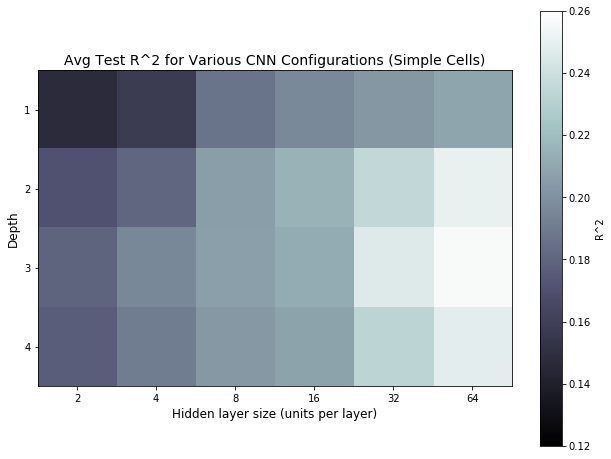

In [6]:
ctype = 'simple'
mtype = 'cnn'
metric = 'r2'

ndepths = hparams[mtype]['ndepths']
nwidths = hparams[mtype]['nwidths']
hidden_sizes = hparams[mtype]['h_sizes']
hidden_layers = hparams[mtype]['h_layers']


lims = {'simple':{'bps':(.35,.75), 'r2':(.12,.26)}, 'complex':{'bps':(0.,.6), 'r2':(0.0,.18)}}
step = {'bps':.05, 'r2':.02}
shape = {'fc':(4,9,cell_nums[ctype]), 'rnn':(3,5,cell_nums[ctype]), 'cnn':(4,6,cell_nums[ctype])} # rnn is 3x4 for complex
labels = {'r2':'R^2', 'bps': 'Bits/Spike' }


data = np.genfromtxt('./SavedResults/' + ctype + '_' + mtype + '_' + metric + '.csv', delimiter=',').reshape(shape[mtype])
avg_data = np.mean(data, axis=2)
plt.imshow(avg_data, 'bone', vmin=lims[ctype][metric][0], vmax=lims[ctype][metric][1], interpolation='nearest')
plt.colorbar(orientation="vertical",fraction=0.1,
             ticks=np.arange(lims[ctype][metric][0], lims[ctype][metric][1]+step[metric], step[metric]), label=labels[metric])
plt.xticks(np.arange(nwidths), hidden_sizes)
plt.xlabel('Hidden layer size (units per layer)', fontsize=12)
plt.yticks(np.arange(ndepths), np.asarray(hidden_layers)+1)
plt.ylabel('Depth', fontsize=12)
plt.title('Avg Test %s for Various %s Configurations (%s Cells)' % (labels[metric],mtype.upper(), ctype[0].upper()+ctype[1:]), fontsize=14)
plt.show()


In [30]:
from mpltools import color

ImportError: No module named 'mpltools'

In [7]:
def get_model(celltype, mtype, metric='r2'):
    path = 'SavedModels/%s_best_%s_%s.h5' % (celltype, mtype, metric)
    print ('loading %s...' % (mtype))
    return load_model(path, custom_objects={'poiss_full': poiss_full})

In [28]:
def plot_psth(models, celltype, metric='r2', data=None, window=(0,-1)):
    cell_num = np.where(data==np.max(data))[2][0]+1 if data is not None else 1
    v1 = V1(celltype, cell_num)
    plt.plot(v1.psth[window[0]:window[1]], label='Repeat Data')
    for m in models:
        flatten = True if m=='fc' else False
        v1 = V1(celltype, cell_num, flatten=flatten)
        nn = get_model(celltype,m,metric=metric)
        rpt_preds = nn.predict(v1.X_rpt)
        model_psth = v1.convert_nn_psth(rpt_preds)
        plt.plot(model_psth[window[0]:window[1]], label=m.upper())
    
    plt.xlabel('Time (ms)', fontsize=14)
    plt.ylabel('Spike Count', fontsize=14)
    plt.legend(fontsize=14)
    plt.title('PSTH for %s Cell' % (celltype[0].upper()+celltype[1:]), fontsize=16)
    plt.show()

building data...
fetching repeat data...
done.
building data...
fetching repeat data...
done.
loading fc...
building data...
fetching repeat data...
done.
loading rnn...
building data...
fetching repeat data...
done.
loading cnn...


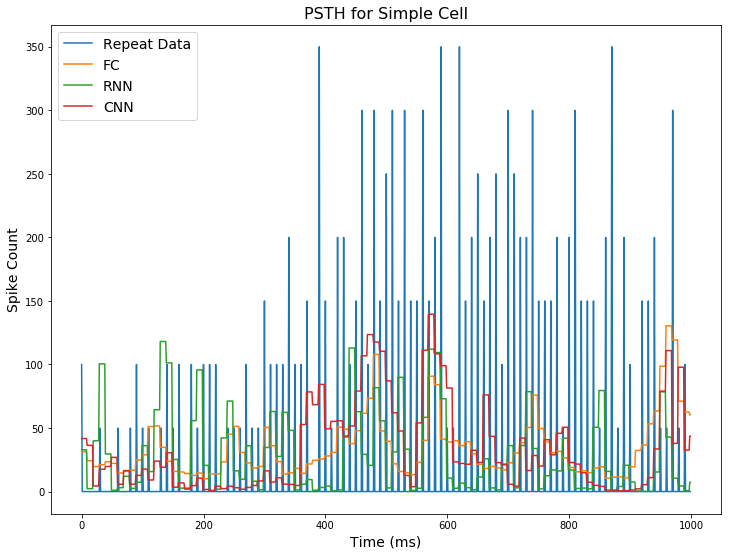

In [29]:
models = ['fc', 'rnn', 'cnn']
plot_psth(models, 'simple', data=data, window=(1000,2000))

In [188]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())
    
print len(weights)

5


(16,)


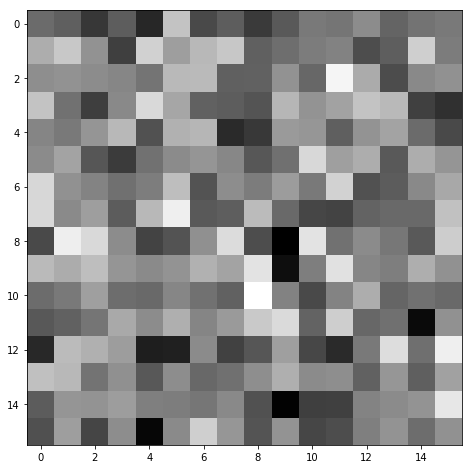

(16,)


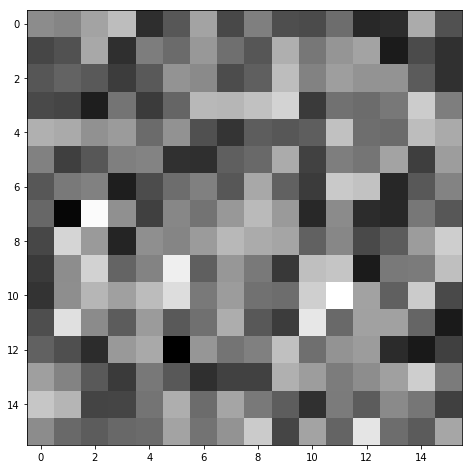

(16,)


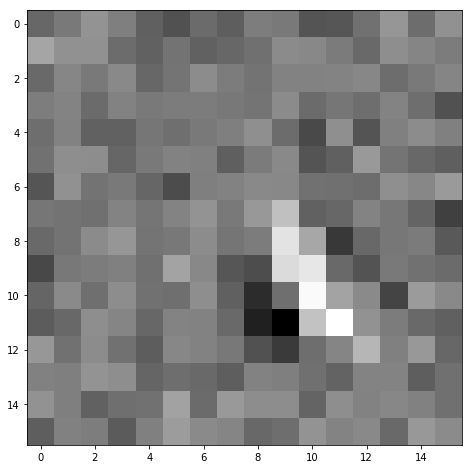

(16,)


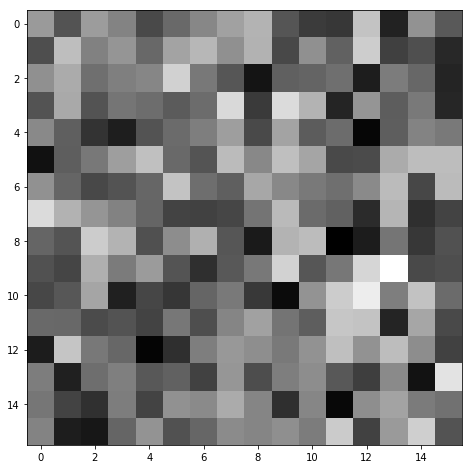

(16,)


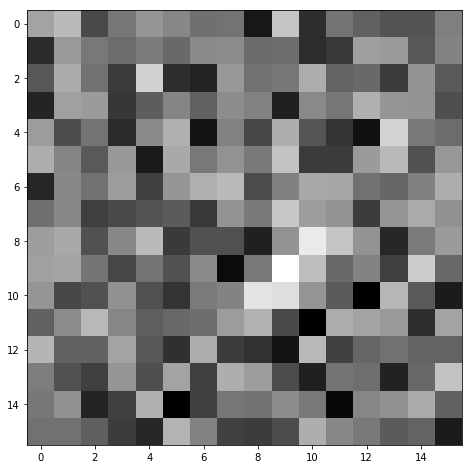

(16,)


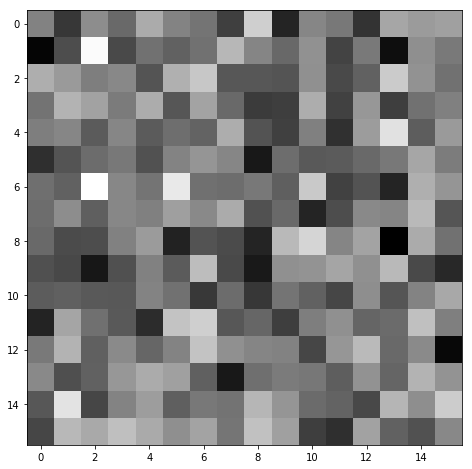

(16,)


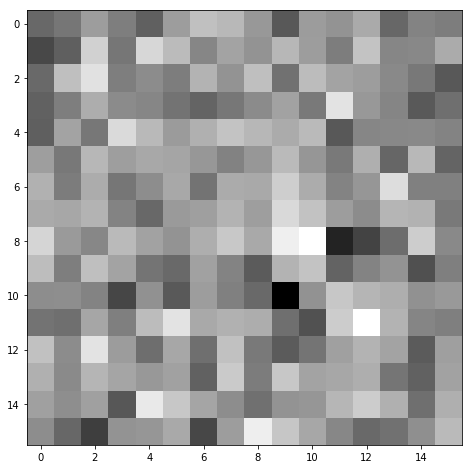

(16,)


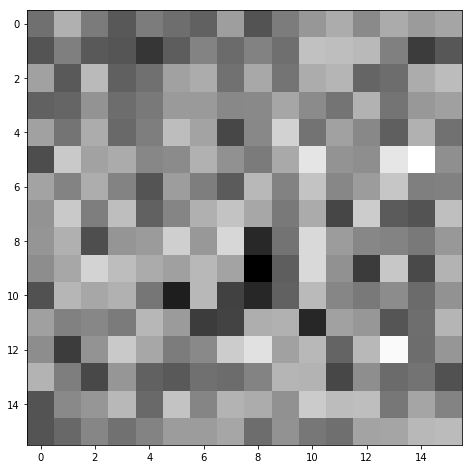

(16,)


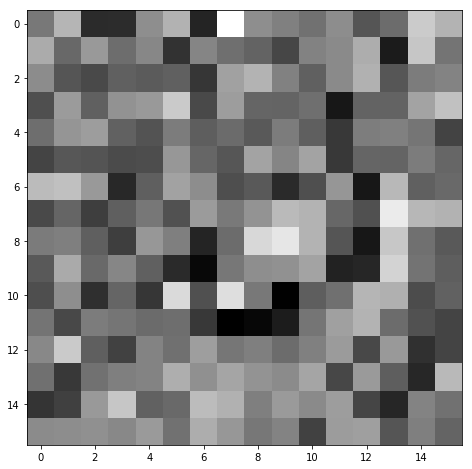

(16,)


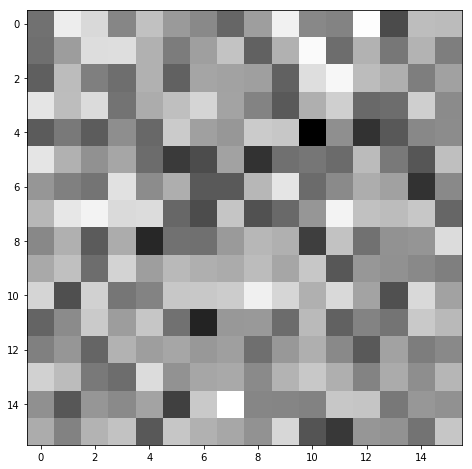

In [190]:
for i in xrange(10):
    wt = weights[0][0][:,i]
    wt = np.reshape(wt, (16,-1))
    avg = np.mean(wt, axis=1)

    plt.imshow(wt)
    plt.show()